# Titanic Survival Exploration with Decision Trees

## Getting Started

Loading the dataset and displaying some of its rows.

In [24]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Pretty display for notebooks
%matplotlib inline

# Set a random seed
import random
random.seed(33)

# Load the datasets
df_train = pd.read_csv('datasets/train.csv')
df_test = pd.read_csv('datasets/test.csv')

In [25]:
# Print the first few entries of the Train Titanic data
df_train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [26]:
# Print the first few entries of the Test Titanic data
df_test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


The Survived column in training set is the target variable. If Suvival = 1 the passenger survived, otherwise he's dead.

## Preprocessing the data

In [27]:
# Splitting data
X_train_raw = df_train.drop('Survived', axis=1)
y_train = df_train['Survived']

# Concatenating kaggle Train and Test dataframes
full_data = pd.concat([X_train_raw, df_test])

# Remove the names of the passengers and Cabin
features = full_data.drop('Name', axis=1)
features = features.drop('Cabin', axis=1)

Checking null values in the dataframe

In [28]:
from collections import Counter

for i in features.columns:
    print(i, Counter(features[i].isnull()))

PassengerId Counter({False: 1309})
Pclass Counter({False: 1309})
Sex Counter({False: 1309})
Age Counter({False: 1046, True: 263})
SibSp Counter({False: 1309})
Parch Counter({False: 1309})
Ticket Counter({False: 1309})
Fare Counter({False: 1308, True: 1})
Embarked Counter({False: 1307, True: 2})


The count variable shows that 263 values are missing in the Age column, 1 in the Fare Column and 2 in the Embarked Column.

In [29]:
Counter(features['Embarked'])

Counter({'S': 914, 'C': 270, 'Q': 123, nan: 2})

One solution is to fill in the null values of Age and Fare with the median. For Embarked Column let's fill with the most common value that is S

In [30]:
# Fill blanks in Age with median age
features['Age'] = features['Age'].fillna(features['Age'].median())

features['Fare'] = features['Fare'].fillna(features['Fare'].median())

features['Embarked'] = features['Embarked'].fillna('S')

Let's check the result.

In [31]:
for i in features.columns:
    print(i, Counter(features[i].isnull()))

PassengerId Counter({False: 1309})
Pclass Counter({False: 1309})
Sex Counter({False: 1309})
Age Counter({False: 1309})
SibSp Counter({False: 1309})
Parch Counter({False: 1309})
Ticket Counter({False: 1309})
Fare Counter({False: 1309})
Embarked Counter({False: 1309})


In [32]:
# Splitting data
X_train = features[:len(X_train_raw)]
X_test = features[-(len(df_test)):]

## Exploratory data analysis

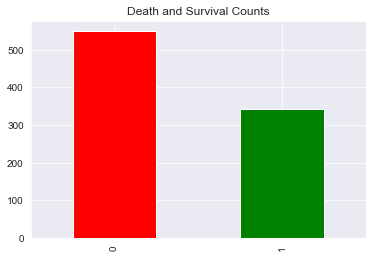

In [33]:
y_train.value_counts().plot(kind='bar', title='Death and Survival Counts',grid=True, color=['r', 'g'])
plt.show()

Most of the people did not survive the accident

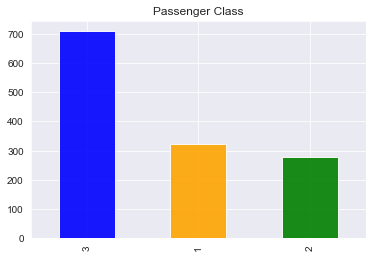

In [34]:
features['Pclass'].value_counts().plot(kind='bar', title='Passenger Class',alpha=0.90,grid=True, color=['blue', 'orange', 'g'])
plt.show()

The largest number of passengers were in class 3 followed by class 1 and class 2.

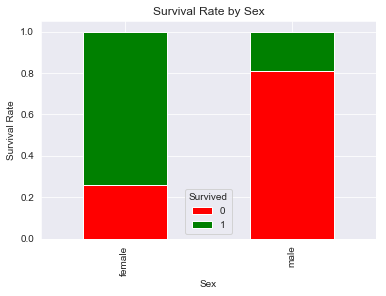

In [35]:
surv_by_sex=pd.crosstab(X_train_raw['Sex'],y_train)
surv_by_sex_normalize = surv_by_sex.div(surv_by_sex.sum(1).astype(float),axis=0)
surv_by_sex_normalize.plot(kind='bar',title='Survival Rate by Sex',stacked=True,grid=True, color=['r', 'g']) 
plt.xlabel('Sex')
plt.ylabel('Survival Rate')
plt.show()

The majority of females survived but majority of males did not

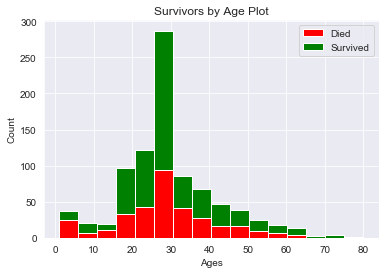

In [36]:
df_full = df_train.fillna(df_train['Age'].median())
survived = df_full[df_full['Survived'] == 1]
not_survived = df_full[df_full['Survived'] == 0]
max_age = max(df_full['Age'])

plt.hist([survived['Age'],not_survived['Age']],bins=16,range=(1, max_age),stacked=True, color=['r', 'g'])
plt.title('Survivors by Age Plot')
plt.xlabel('Ages')
plt.ylabel('Count')
plt.legend(('Died', 'Survived'))
plt.show()

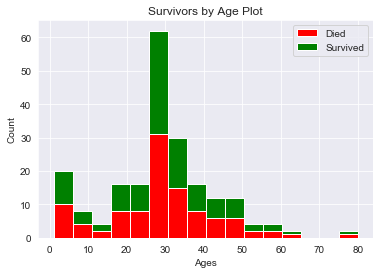

In [37]:
survived_male = survived[survived['Sex'] == 'male']
not_survived_male = survived[survived['Sex'] == 'male']
max_age = max(df_full['Age'])

plt.hist([survived_male['Age'],not_survived_male['Age']],bins=16,range=(1, max_age),stacked=True, color=['r', 'g'])
plt.title('Survivors by Age Plot')
plt.xlabel('Ages')
plt.ylabel('Count')
plt.legend(('Died', 'Survived'))
plt.show()


It seems that young male tend to survive and a large number of passengers between 20 and 40 passed away

In [38]:
women_children = []

for _, passenger in features.iterrows():
    if passenger['Sex'] == 'female' or passenger['Age'] <= 16:
        women_children.append(1)
    else:
        women_children.append(0)
    
# Our women_children feature
women_children = pd.Series(women_children)

features['women_children'] = women_children

features.head(1)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,women_children
0,1,3,male,22.0,1,0,A/5 21171,7.25,S,0


## Training first model

In [51]:
# One-hot encoding
data = pd.get_dummies(features.drop('Fare', axis=1).drop('Ticket', axis=1).drop('SibSp', axis=1).drop('Embarked', axis=1))

data.head(1)

,PassengerId,Pclass,Age,Parch,women_children,Sex_female,Sex_male
0,1,3,22.0,0,0,0,1


In [52]:
# Import the classifier from sklearn
from sklearn.tree import DecisionTreeClassifier

X_train = data[:len(X_train_raw)]
X_test = data[-(len(df_test)):]

# Define the classifier, and fit it to the data
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Testing first model

In [41]:
# Making predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the accuracy for training
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train, y_train_pred)
print('The training accuracy is', train_accuracy)

# Score of the first model = 0.74641

The training accuracy is 1.0


## Saving Predictions CSV file

In [42]:
# Prediction.csv for kaggle competition

def predictions_to_csv(y, file_name):
    '''This function save a predictions array to csv file'''
    df = pd.DataFrame()
    df['PassengerId'] = X_test['PassengerId']
    df['Survived'] = y
    df.to_csv(file_name, index=False)

# Save CSV
predictions_to_csv(y_test_pred, 'first-predictions.csv')

## Improving the model

In [43]:
# Train the new model
decision_tree = DecisionTreeClassifier(random_state=33)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=33,
            splitter='best')

Hyperparameter optimization with GridSearch

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, make_scorer

parameters = {'max_depth':[2,4,6,8,10,12,14,16], 'min_samples_leaf':[2,4,6,8,10,12,14,16], 'min_samples_split':[2,4,6,8,10,12,14,16]}

scorer = make_scorer(f1_score)

grid_obj = GridSearchCV(decision_tree, parameters, scoring=scorer)
grid_fit = grid_obj.fit(X_train, y_train)

# Get the best estimator
best_clf = grid_fit.best_estimator_

# Fit the new model
best_clf.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=12, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=33,
            splitter='best')

In [45]:
# Make predictions
best_train_predictions = best_clf.predict(X_train)

# Calculate the accuracy
train_accuracy = accuracy_score(y_train, best_train_predictions)
print('The training accuracy is', train_accuracy)

The training accuracy is 0.8383838383838383


In [46]:
# Calculate the f1_score of the new model.
print('The training F1 Score is', f1_score(best_train_predictions, y_train))

The training F1 Score is 0.7728706624605679


In [47]:
# Save predicts to csv
y_test_pred = best_clf.predict(X_test)

predictions_to_csv(y_test_pred, 'dtree-predictions.csv')

## RandomForest

In [53]:
from sklearn.ensemble import RandomForestClassifier

RandomForest = RandomForestClassifier(n_estimators=1000)
RandomForest.fit(X_train, y_train)
y_train_pred = RandomForest.predict(X_train)
print ("RandomForest Accuracy = %.2f" % (accuracy_score(y_train, y_train_pred)))

RandomForest Accuracy = 1.00


In [54]:
# Save predicts to csv
y_test_pred = RandomForest.predict(X_test)

predictions_to_csv(y_test_pred, 'randf-predictions.csv')

## Logistic Regression

In [63]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
y_train_pred = logistic_regression.predict(X_train)
print ("Logistic Regression Accuracy = %.2f" % (accuracy_score(y_train, y_train_pred)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression Accuracy = 0.81


In [64]:
# Save predicts to csv
y_test_pred = RandomForest.predict(X_test)

predictions_to_csv(y_test_pred, 'logreg-predictions.csv')